<a href="https://colab.research.google.com/github/DerekZ66/ALY6110/blob/main/ALY6110_ASS2_Yude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setting up the Pyspark in Colab

In [4]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark


In [5]:
# preparation for spark
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [6]:
# Create SparkSession from builder
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[1]") \
                    .appName('ALY6110_ASS2_Yude') \
                    .getOrCreate()

In [7]:
# run spark
spark

In [8]:
# mount drive to colab
from google.colab import drive
drive.mount('/content/drive')

# read data set from drive
df = spark.read.csv('/content/drive/MyDrive/BostonHousing.csv',inferSchema=True, header=True)
df.printSchema()

Mounted at /content/drive
root
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- b: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



In [9]:
# Display summary statistics
df.describe().show()

+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|summary|              crim|                zn|             indus|              chas|                nox|                rm|               age|              dis|              rad|               tax|           ptratio|                 b|             lstat|              medv|
+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|  count|               506|               506|               506|               506|                506|               506|               506|              506|              

In [10]:
# Drop rows with missing values
df_cleaned = df.dropna()

In [19]:
# install seaborn
!pip install seaborn matplotlib


In [22]:
# import required packages
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

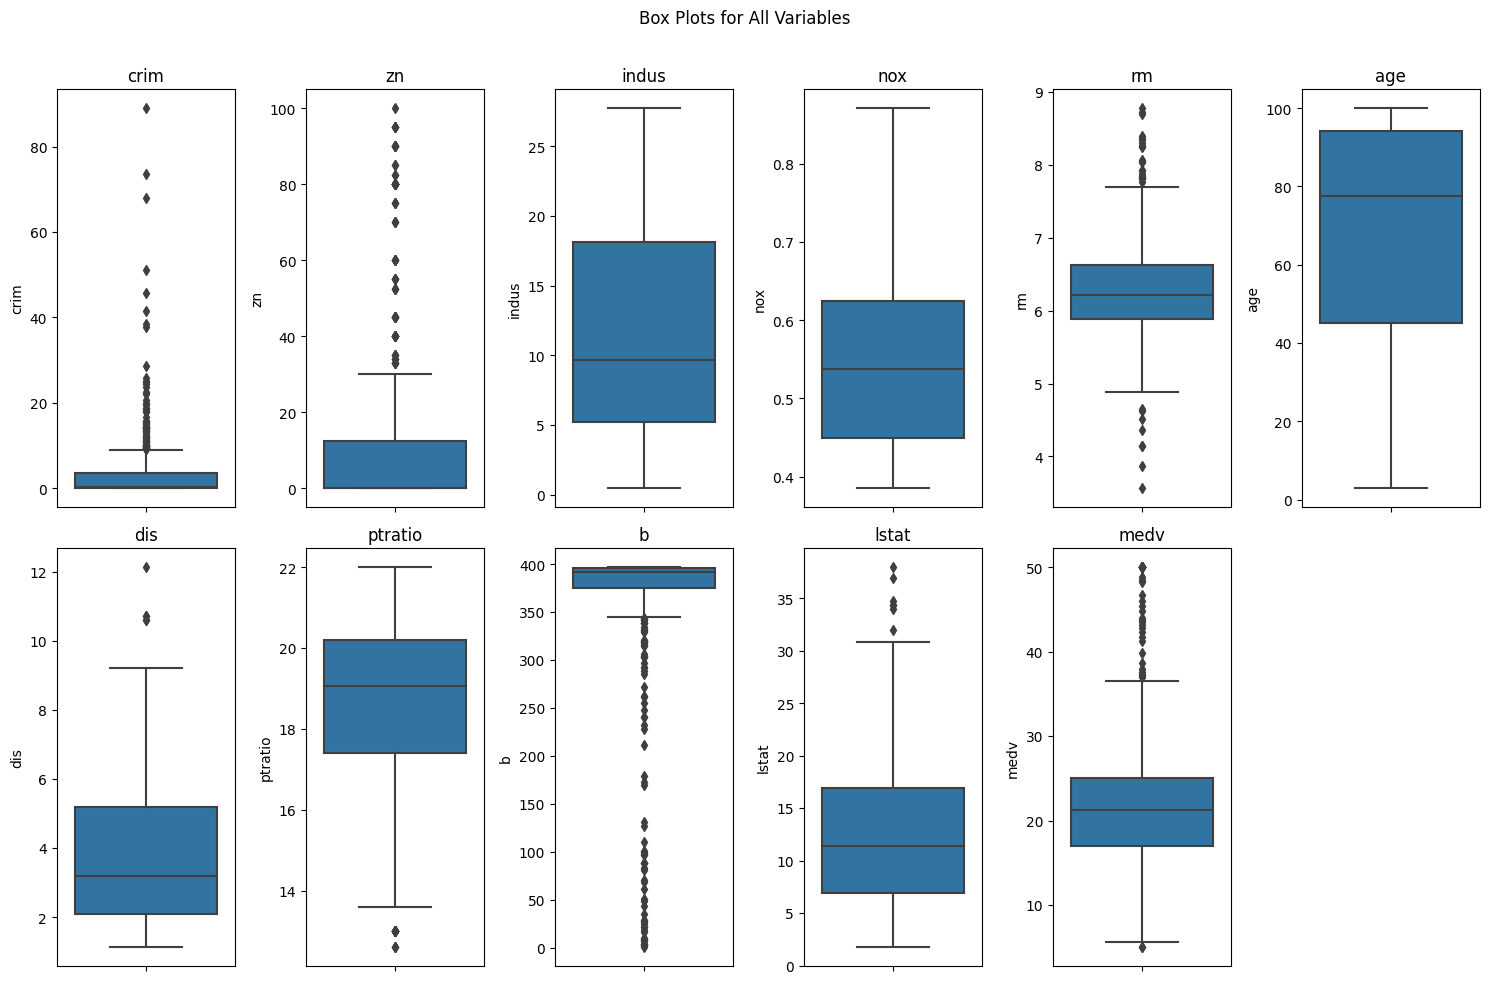

In [42]:
# Get all numerical column names
numeric_cols = [col_name for col_name, dtype in pandas_df.dtypes.items() if dtype == 'float']

# Calculate the number of rows and columns for subplots
num_vars = len(pandas_df.columns)
num_rows = 2
num_cols = (num_vars + 1) // 2

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
fig.suptitle('Box Plots for All Variables')

# Flatten the axes for easier iteration
axes = axes.flatten()

# Iterate through each variable and plot the box plot
for i, col in enumerate(pandas_df.columns):
    ax = axes[i]
    sns.boxplot(y=pandas_df[col], ax=ax)
    ax.set_title(col)

# Hide empty subplots
for i in range(num_vars, num_rows * num_cols):
    fig.delaxes(axes[i])

# show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

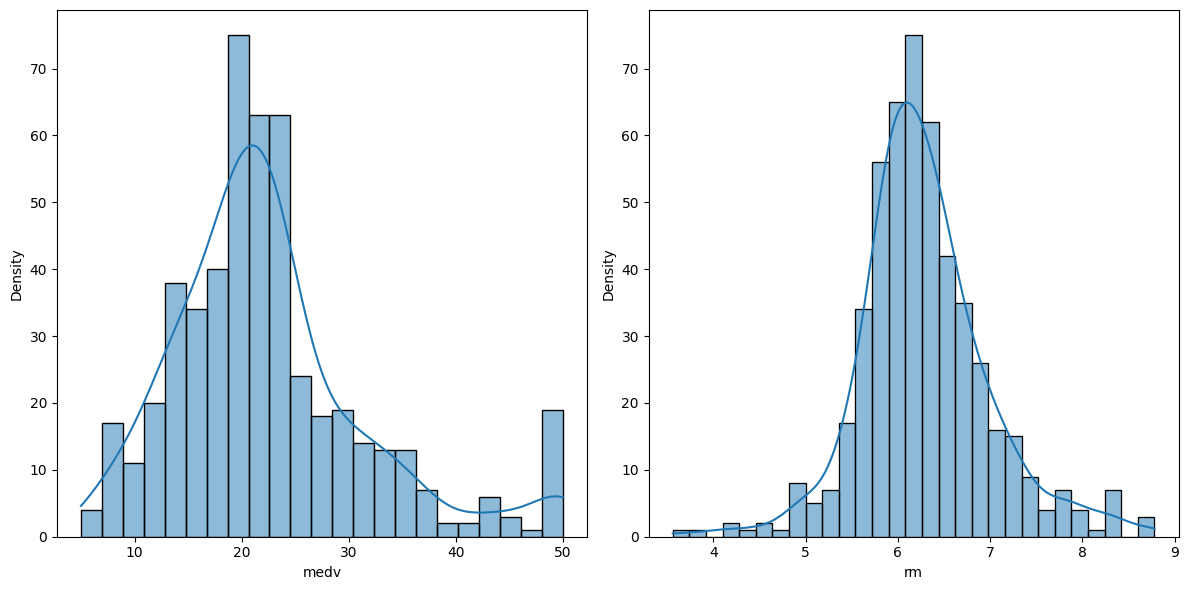

In [70]:
# Select the variables for plotting
variables_to_plot = ['medv', 'rm']

# Convert the PySpark DataFrame to a Pandas DataFrame and select the variables to plot
pandas_df = df.select(variables_to_plot).toPandas()

# Plot histograms with density using Seaborn
plt.figure(figsize=(12, 6))

for i, var in enumerate(variables_to_plot, 1):
    plt.subplot(1, len(variables_to_plot), i)
    sns.histplot(pandas_df[var], kde=True)
    plt.xlabel(var)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

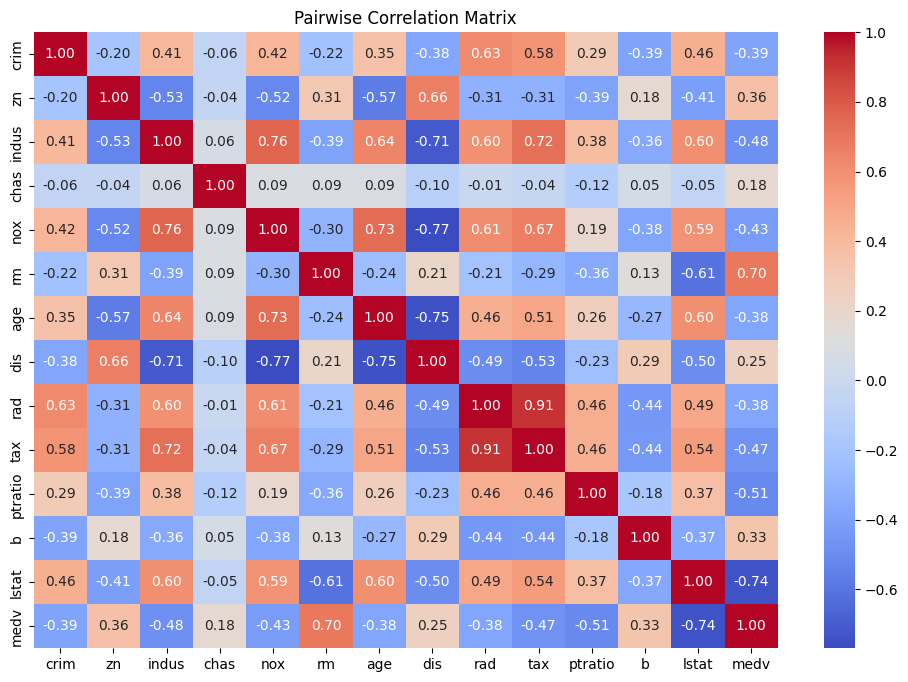

In [ ]:

# Calculate the pairwise correlation matrix
correlation_matrix = df.toPandas().corr()

# Plot the correlation heatmap with correlation valuss as annotations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size': 10})
plt.title('Pairwise Correlation Matrix')
plt.show()


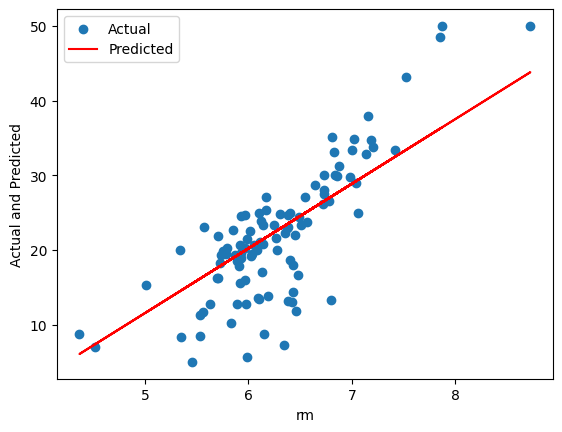

In [93]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
import numpy as np


# Select the variables for linear regression
independent_variable = 'rm'
dependent_variable = 'medv'

# Prepare the data for modeling
assembler = VectorAssembler(inputCols=[independent_variable], outputCol='features_col')
assembled_df = assembler.transform(df).withColumnRenamed(dependent_variable, 'label')

# Split the data into training and testing sets
train_df, test_df = assembled_df.randomSplit([0.8, 0.2], seed=123)

# Train the linear regression model
lr = LinearRegression(featuresCol='features_col', labelCol='label')
lr_model = lr.fit(train_df)

# Make predictions on the test set
predictions = lr_model.transform(test_df)

# Visualize the results
predictions_pd = predictions.toPandas()
plt.scatter(predictions_pd[independent_variable], predictions_pd['label'], label='Actual')
plt.plot(predictions_pd[independent_variable], predictions_pd['prediction'], color='red', label='Predicted')
plt.xlabel(independent_variable)
plt.ylabel('Actual and Predicted')
plt.legend()
plt.show()

In [94]:
# Get the coefficients and intercept
coefficients = lr_model.coefficients
intercept = lr_model.intercept

# Display the coefficients and intercept
print("Coefficients: {}".format(coefficients))
print("Intercept: {}".format(intercept))

Coefficients: [8.663371587593756]
Intercept: -31.783865289578678


In [95]:
from pyspark.ml.evaluation import RegressionEvaluator


# Evaluate the model using Mean Squared Error (MSE)
evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='mse')
mse = evaluator.evaluate(predictions)
print("Mean Squared Error (MSE):", mse)

# Evaluate the model using R-squared (R²)
evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='r2')
r2 = evaluator.evaluate(predictions)
print("R-squared (R²):", r2)

Mean Squared Error (MSE): 30.72953852404244
R-squared (R²): 0.6113846770788728


In [80]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when

# Calculate the average number of rooms ("RM")
average_rm = df.agg({"RM": "avg"}).collect()[0][0]

# Define bins based on average_rm
# For simplicity, let's say we categorize into 3 bins: low, medium, high based on RM values
low_bin = average_rm - 1.0
high_bin = average_rm + 1.0

# Categorize records into bins based on RM
df_with_bins = df.withColumn("RM_category",
                when(col("RM") < low_bin, "Low")
                .when((col("RM") >= low_bin) & (col("RM") <= high_bin), "Medium")
                .when(col("RM") > high_bin, "High")
                .otherwise("Unknown"))

# Show the DataFrame with the new RM_category column
df_with_bins.select("RM", "RM_category").show()


+-----+-----------+
|   RM|RM_category|
+-----+-----------+
|6.575|     Medium|
|6.421|     Medium|
|7.185|     Medium|
|6.998|     Medium|
|7.147|     Medium|
| 6.43|     Medium|
|6.012|     Medium|
|6.172|     Medium|
|5.631|     Medium|
|6.004|     Medium|
|6.377|     Medium|
|6.009|     Medium|
|5.889|     Medium|
|5.949|     Medium|
|6.096|     Medium|
|5.834|     Medium|
|5.935|     Medium|
| 5.99|     Medium|
|5.456|     Medium|
|5.727|     Medium|
+-----+-----------+
only showing top 20 rows



In [81]:
average_rm

6.284634387351787

In [83]:
from pyspark.sql.functions import col, avg, count


# Calculate the average number of rooms ("RM")
average_rm = df.agg({"RM": "avg"}).collect()[0][0]

# Define bins based on average_rm
low_bin = average_rm - 1.0
high_bin = average_rm + 1.0

# Categorize records into bins based on RM
df_with_bins = df.withColumn("RM_category",
                when(col("RM") < low_bin, "Low(<5.28)")
                .when((col("RM") >= low_bin) & (col("RM") <= high_bin), "Medium")
                .when(col("RM") > high_bin, "High(>7.28)")
                .otherwise("Unknown"))

# Calculate statistics for each bin
bin_statistics = df_with_bins.groupBy("RM_category") \
          .agg(
          count("RM").alias("count"),
            avg("MEDV").alias("average_price"),
             )

# Show the statistics for each bin
bin_statistics.show()

+-----------+-----+------------------+
|RM_category|count|     average_price|
+-----------+-----+------------------+
|High(>7.28)|   39|41.430769230769236|
|     Medium|  443|21.258690744921015|
| Low(<5.28)|   24|15.341666666666663|
+-----------+-----+------------------+



In [96]:
spark.stop()